In [1]:
import fiona
import pandas as pd
import geopandas as gpd
from nansat import Nansat

import rasterio as rio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
%matplotlib inline

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et

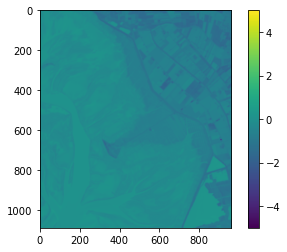

In [2]:
### Opening all images manually

src_ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
src_awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
src_bands = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
src_vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

ndwi = Nansat(src_ndwi)
awei = Nansat(src_awei)
bands = Nansat(src_bands)
vis = Nansat(src_vis)

# Stack as list of bands
dst_stack = [ndwi[1], awei[1], bands[1], bands[2], bands[2], bands[3], bands[4], bands[5], bands[6], vis[1], vis[2], vis[3], vis[4]]
plt.imshow(dst_stack[1], vmin=-5, vmax=5);plt.colorbar()
plt.show()

In [15]:
type(dst_stack)

list

In [68]:
# Stack as multi-dimensional np array
import numpy as np
all_bands = [bands[band_n] for band_n in bands.bands().keys()]
all_bands.append(ndwi[1])
all_bands.append(awei[1])
for band_n in vis.bands().keys():
    all_bands.append(vis[band_n])
lon_grd, lat_grd = ndwi.get_geolocation_grids()
all_bands.append(lon_grd)
all_bands.append(lat_grd)

all_bands = np.array(all_bands)

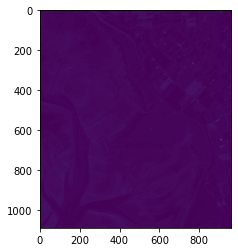

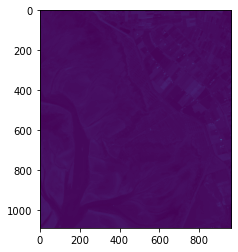

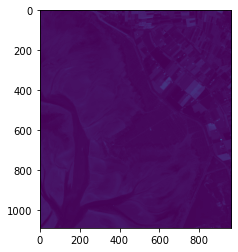

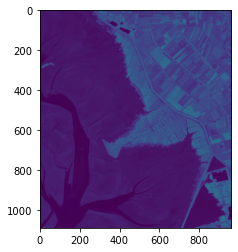

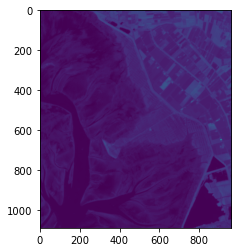

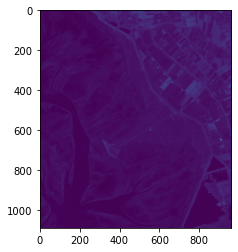

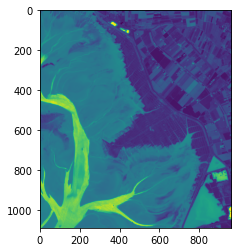

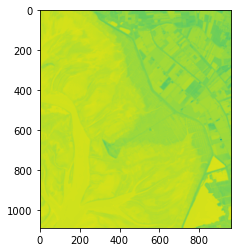

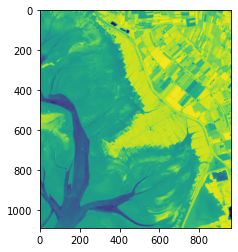

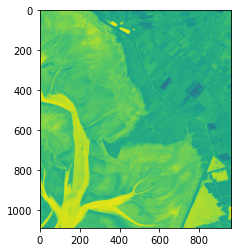

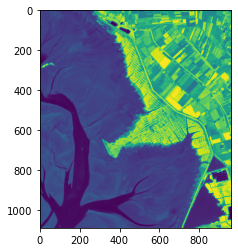

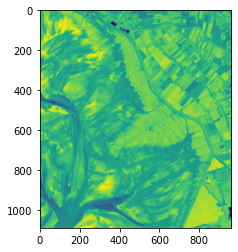

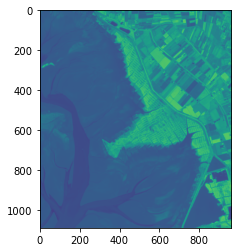

In [5]:
for i in range(all_bands.shape[0]):
    plt.figure()
    plt.imshow(all_bands[i, :, :])

In [6]:
all_bands[:, 10 , 10]

array([ 3.5200000e+02,  6.1900000e+02,  5.9500000e+02,  8.4500000e+02,
        5.2200000e+02,  2.9100000e+02, -1.5437157e-01, -6.2350001e-02,
        1.7361110e-01,  2.3680124e+00,  1.5146969e-01,  2.3628382e-01,
        5.3078551e-02], dtype=float32)

In [7]:
#whatever = [src_ndwi, src_awei, src_bands, src_vis]
#land_stack, land_meta = es.stack(whatever,
#                                 out_path=r_stack_path)   # does the same as upcoming glob list stack

# b2 = bands[0]
# Results in: "TypeError: 'DatasetReader' object is not subscriptable"  --> rio.open only creates connection to raster file, without actually reading the values of the data set - xy.read() does this
# and creates an ndarray object

In [9]:
# stack with earthpy
# creating glob list to not type all images manually
from glob import glob
multi_bands = glob("/container_dir1/subsets/*S2*.tif")
multi_bands

['/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif',
 '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif',
 '/container_dir1/subsets/Subset_S2_20210716_resampled.tif',
 '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif']

In [10]:
r_stack_path = "/container_dir1/results/july_rasterstack.tif"
land_stack, land_meta = es.stack(multi_bands,
                                 out_path=r_stack_path)

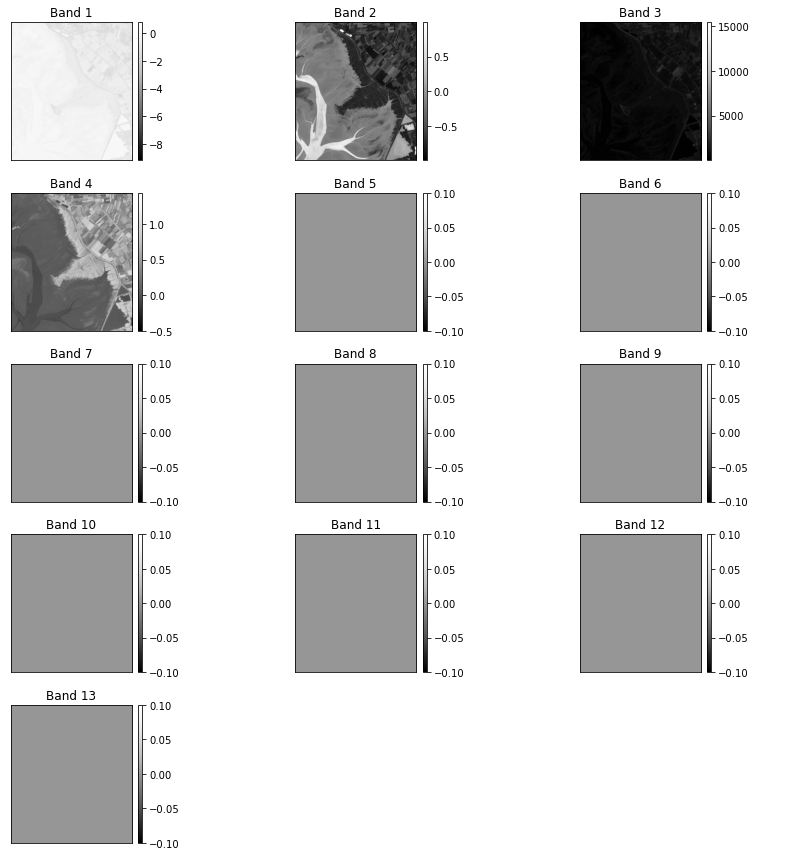

In [11]:
with rio.open(r_stack_path) as src:
    stack = src.read()

#stack = Nansat(r_stack_path)
ep.plot_bands(stack, cbar=True)
plt.show()
# only first band of VIs + S2 multiband images gets written correctly in the stack with this method
# so raster stack from band 5 to band 13 are pictures with no values

In [12]:
type(stack)

numpy.ndarray

In [18]:
### More stacking fun, this time with rasterio
# Read metadata of first file
with rio.open(multi_bands[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(multi_bands))

# Read each layer and write to stack
with rio.open('/container_dir1/results/july_rasterstack2.tif', 'w', **meta) as dst:
    for id, layer in enumerate(multi_bands, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))                    
type(dst)
# again, only first bands of VIs and S2 get written, in this case raster stack consists only of 4 bands

rasterio.io.DatasetWriter

In [27]:
### checking stack properties
with rio.open('/container_dir1/results/july_rasterstack2.tif') as src3:
    dst_stack2 = src3.read()
    dst_stack2_meta = src3.meta
type(dst_stack2)

numpy.ndarray

In [28]:
dst_stack2.shape

(4, 1091, 960)

In [29]:
# df = gpd.read_file('/container_dir1/land_mask_HH.shp').to_crs(32632)
# df.to_file('/container_dir1/results/lm_HH_crs.shp')

In [30]:
### masking land with aoi shapefile
with fiona.open('/container_dir1/subsets/aoi.shp') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rio.open('/container_dir1/results/july_rasterstack2.tif') as src4:
    out_image, transformed = rio.mask.mask(src4, shapes, crop=True, filled=True)
    out_meta = src4.meta

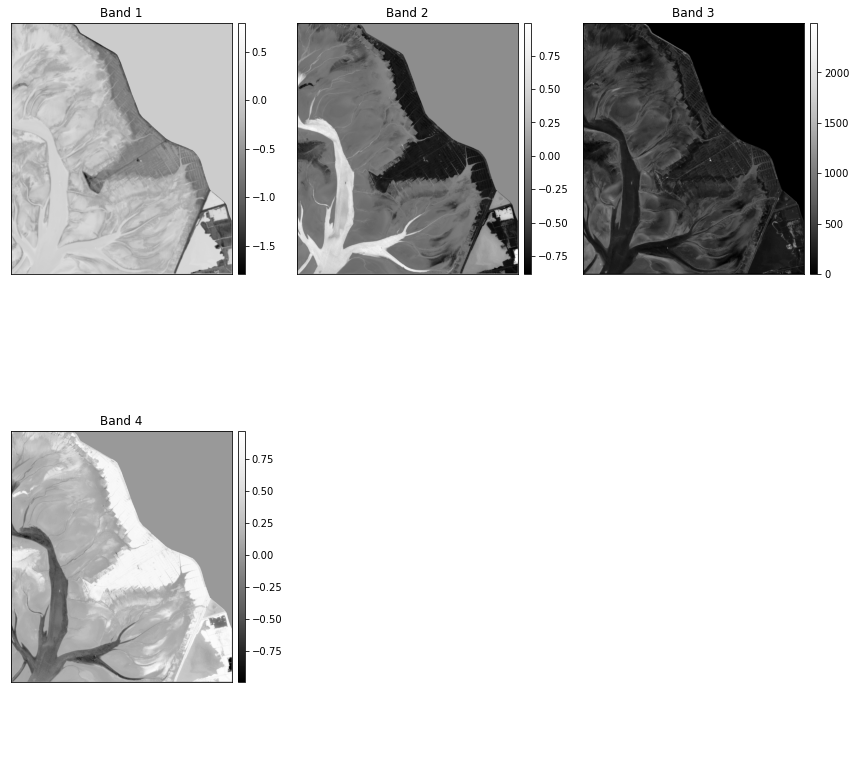

In [31]:
# plt.imshow(out_image[0])
# plt.colorbar()
# plt.show()

ep.plot_bands(out_image, cbar=True)
plt.show()

In [32]:
### Export masked image
masked_path = '/container_dir1/results/aoi_rasterstack.tif'

Text(0.5, 1.0, 'B12')

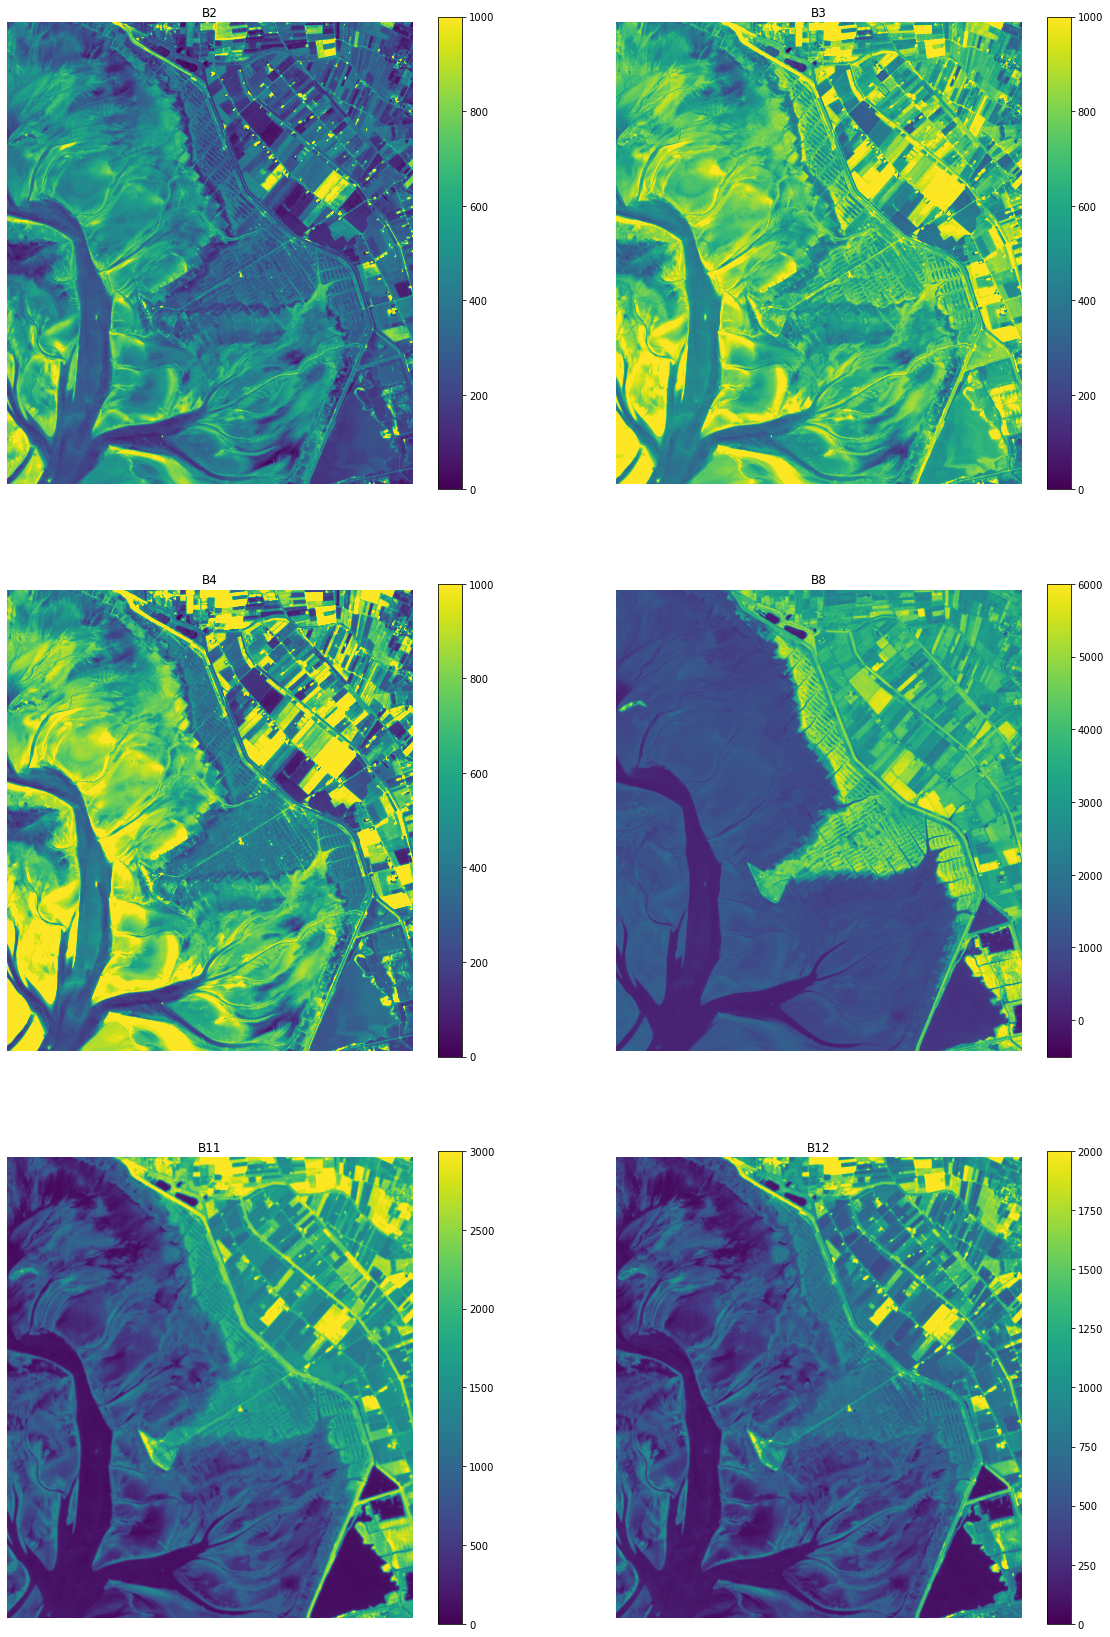

In [17]:
### Plot all bands of the july subset

s2_july = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
july = Nansat(s2_july)

b2 = july[1]
b3 = july[2]
b4 = july[3]
b8 = july[4]
b11 = july[5]
b12 = july[6]

bands = [b2, b3, b4, b8, b11, b12]

fig = plt.figure(figsize=(20,40))

fig.add_subplot(4, 2, 1)
plt.imshow(b2, vmin=0, vmax=1000);plt.colorbar()
plt.axis('off')
plt.title('B2')

fig.add_subplot(4, 2, 2)
plt.imshow(b3, vmin=0, vmax=1000);plt.colorbar()
plt.axis('off')
plt.title('B3')

fig.add_subplot(4, 2, 3)
plt.imshow(b4, vmin=0, vmax=1000);plt.colorbar()
plt.axis('off')
plt.title('B4')

fig.add_subplot(4, 2, 4)
plt.imshow(b8, vmin=-500, vmax=6000);plt.colorbar()
plt.axis('off')
plt.title('B8')

fig.add_subplot(4, 2, 5)
plt.imshow(b11, vmin=0, vmax=3000);plt.colorbar()
plt.axis('off')
plt.title('B11')

fig.add_subplot(4, 2, 6)
plt.imshow(b12, vmin=0, vmax=2000);plt.colorbar()
plt.axis('off')
plt.title('B12')

# plt.show()

In [36]:
### Write a loop or something for the plotting instead of those twenty copy/paste whatever lines

In [63]:
### now import new set of trainig points with more points, extract pixel values of the raster stack at the point locations and add them to table of points
### but for that we need to know which band displays what, so I have to add correct titles to raster stack bands

src_t_points = '/container_dir1/subsets/t_points_new2.shp'
points = gpd.read_file(src_t_points)

In [64]:
class_names = points['classtxt'].unique()
print(class_names)
points

['water' 'structures' 'seabed' 'lsm' 'pioneer' 'usm']


id  classid classtxt  vertex_ind  vertex_par  vertex_p_1    distance  \
0      None        1    water           0           0           0    0.000000   
1      None        1    water           1           0           1    9.984770   
2      None        1    water           2           0           2   19.969540   
3      None        1    water           3           0           3   29.954310   
4      None        1    water           4           0           4   39.939081   
...     ...      ...      ...         ...         ...         ...         ...   
14140  None        5      lsm          29           0          29  278.934684   
14141  None        5      lsm          30           0          30  288.683150   
14142  None        5      lsm          31           0          31  298.431617   
14143  None        5      lsm          32           0          32  308.180083   
14144  None        5      lsm          33           0          33  317.928549   

            angle         x          y                        geometry  
0       42.297056  8.784622  54.564908  POINT (486073.904 6046397.927)  
1       42.297056  8.784725  54.564975  POINT (486080.623 6046405.312)  
2       42.297056  8.784829  54.565041  POINT (486087.343 6046412.697)  
3       42.297056  8.784933  54.565108  POINT (486094.062 6046420.083)  
4       42.297056  8.785036  54.565175  POINT (486100.782 6046427.468)  
...           ...       ...        ...                             ...  
14140  312.978635  8.833388  54.609927  POINT (489238.936 6051398.693)  
14141  312.978635  8.833277  54.609987  POINT (489231.804 6051405.338)  
14142  312.978635  8.833167  54.610047  POINT (489224.672 6051411.984)  
14143  312.978635  8.833056  54.610106  POINT (489217.540 6051418.630)  
14144  312.978635  8.832945  54.610166  POINT (489210.408 6051425.276)  

[14145 rows x 11 columns]

In [66]:
# create new working gdf with only the interesting columns and without the qgis stuff in original table
points2 = points[['classid', 'classtxt', 'geometry', 'x', 'y']].copy()

# Rename x and y to lon and lat
points2.rename(columns={'x':'lon', 'y':'lat'}, inplace=True)

points2

classid classtxt                        geometry       lon        lat
0            1    water  POINT (486073.904 6046397.927)  8.784622  54.564908
1            1    water  POINT (486080.623 6046405.312)  8.784725  54.564975
2            1    water  POINT (486087.343 6046412.697)  8.784829  54.565041
3            1    water  POINT (486094.062 6046420.083)  8.784933  54.565108
4            1    water  POINT (486100.782 6046427.468)  8.785036  54.565175
...        ...      ...                             ...       ...        ...
14140        5      lsm  POINT (489238.936 6051398.693)  8.833388  54.609927
14141        5      lsm  POINT (489231.804 6051405.338)  8.833277  54.609987
14142        5      lsm  POINT (489224.672 6051411.984)  8.833167  54.610047
14143        5      lsm  POINT (489217.540 6051418.630)  8.833056  54.610106
14144        5      lsm  POINT (489210.408 6051425.276)  8.832945  54.610166

[14145 rows x 5 columns]

In [37]:
### Try to plot shp against tif

#fig, ax = plt.subplots(figsize=(10,10))

#ep.plot_bands(out_image,
#              extent=plotting_extent(out_image,
#                                     out_image.rio.transform()),
#              scale=False,
#              ax=ax)
#points2.plot(ax=ax,
#             marker='s',
#             markersize=45,
#             color='purple')
#ax.set_axis_off()
#plt.show()

In [38]:
with rio.open('/container_dir1/results/july_rasterstack2.tif') as src5:
    transform = src5.transform
transform

Affine(10.0, 0.0, 484550.0,
       0.0, -10.0, 6057160.0)

In [39]:
transform.to_gdal()

(484550.0, 10.0, 0.0, 6057160.0, 0.0, -10.0)

In [40]:
### If I want to buffer around points:
#points_poly = points2.copy()
#points_poly['geometry'] = points2.geometry.buffer(1)
#points_poly.head()
#output_points = '/container_dir1/results/tpoints_buffer.shp'
#points_poly.to_file(output_points)

In [41]:
raster = '/container_dir1/results/july_rasterstack2.tif' # not the masked raster yet!
points2 = pd.DataFrame(points2)

In [42]:
zs = zonal_stats(vectors=points2['geometry'], raster=raster, stats='max')

/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [43]:
stats = pd.DataFrame(zs).fillna(-999)

In [44]:
results = pd.merge(left=points2, right=stats, how='left', left_index=True, right_index=True)

In [45]:
# results = results.reindex(sorted(results.columns), axis=1) #Sort columns by name, not necessary

In [46]:
zs[1]

{'max': 0.03819999843835831}

In [47]:
results.head()

classid classtxt                        geometry       max
0        1    water  POINT (486073.904 6046397.927)  0.035225
1        1    water  POINT (486080.623 6046405.312)  0.038200
2        1    water  POINT (486087.343 6046412.697)  0.038150
3        1    water  POINT (486094.062 6046420.083)  0.046325
4        1    water  POINT (486100.782 6046427.468)  0.049250

In [52]:
results.rename(columns={'max':'ndwi'}, inplace=True)

In [ ]:
zs = zonal_stats(vectors=results['geometry'], raster=raster, stats='max')

In [50]:
def ZonalStats(shape, raster, stats):
    # shape - shapefile path
    # raster - raster path
#    shape_gdf = gpd.read_file(shape)
    zonalSt = zonal_stats(vectors=shape['geometry'], raster=raster, stats=stats)
    df = pd.DataFrame(zonalSt).fillna(-999)
#   df_concat = pd.concat([df, shape_gdf], axis=1)
    final_df = pd.merge(left=df, right=zonalSt, how='left', left_index=True, right_index=True)
#   final_gdf = gpd.GeoDataFrame(df_concat, geometry=df_concat.geometry)
    return final_df
    
ndwi_df = ZonalStats(points2, src_ndwi, 'max')

/opt/conda/lib/python3.7/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


KeyboardInterrupt: 

In [ ]:
ndwi_df.head()

In [ ]:
ndwi_df.rename(columns={'max':'ndwi'}, inplace=True)

In [ ]:
awei_ndwi_df = Zonalstats(ndwi_df, src_awei, 'max')

In [54]:
#all_bands = np.array(all_bands)
lon_grd, lat_grd = ndwi.get_geolocation_grids()

lon_grd

array([[8.76048644, 8.76064146, 8.76079649, ..., 8.90884495, 8.90899997,
        8.909155  ],
       [8.76048697, 8.76064199, 8.76079702, ..., 8.90884515, 8.90900017,
        8.9091552 ],
       [8.7604875 , 8.76064252, 8.76079754, ..., 8.90884535, 8.90900037,
        8.9091554 ],
       ...,
       [8.76105988, 8.76121453, 8.76136919, ..., 8.90906319, 8.90921785,
        8.9093725 ],
       [8.76106041, 8.76121506, 8.76136971, ..., 8.90906339, 8.90921805,
        8.9093727 ],
       [8.76106093, 8.76121558, 8.76137024, ..., 8.90906359, 8.90921825,
        8.9093729 ]])

In [60]:
arrays_flat = [all_bands[i, :, :].flatten() for i in range(all_bands.shape[0])] 

raster_df = pd.DataFrame({
    "B2" : arrays_flat[0],
    "B3" : arrays_flat[1],
    "B4" : arrays_flat[2],
    "B8" : arrays_flat[3],
    "B11" : arrays_flat[4],
    "B12" : arrays_flat[5],
    "NDWI" : arrays_flat[6],
    "AWEI" : arrays_flat[7],
    "NDVI" : arrays_flat[8],
    "SAVI" : arrays_flat[9],
    "MSAVI" : arrays_flat[10],
    "NDMI" : arrays_flat[10],
    "EVI" : arrays_flat[11]})
    
raster_df.head()      

B2     B3     B4      B8    B11    B12      NDWI      AWEI      NDVI  \
0  157.0  335.0  284.0  1009.0  445.0  271.0 -0.501488 -0.143750  0.560712   
1  183.0  320.0  273.0  1019.0  373.0  229.0 -0.522031 -0.109650  0.577399   
2  193.0  355.0  315.0   930.0  373.0  229.0 -0.447471 -0.093425  0.493976   
3  229.0  421.0  375.0   873.0  340.0  208.0 -0.349304 -0.046625  0.399038   
4  195.0  379.0  350.0   846.0  340.0  208.0 -0.381224 -0.062750  0.414716   

       SAVI     MSAVI      NDMI       EVI  
0  2.498808  0.193002  0.193002  0.387895  
1  2.502543  0.195318  0.195318  0.464080  
2  2.500400  0.176438  0.176438  0.427475  
3  2.480474  0.163394  0.163394  0.439406  
4  2.500968  0.158798  0.158798  0.426644

In [62]:
type(raster_df)

pandas.core.frame.DataFrame

In [61]:
zs = zonal_stats(points2,
                 raster_df,
                 affine=transform,
                 geojson_out=True,
                 copy_properties=True,
                 stats='max')
type(zs)

TypeError: invalid path or file:             B2     B3     B4      B8     B11    B12      NDWI      AWEI  \
0        157.0  335.0  284.0  1009.0   445.0  271.0 -0.501488 -0.143750   
1        183.0  320.0  273.0  1019.0   373.0  229.0 -0.522031 -0.109650   
2        193.0  355.0  315.0   930.0   373.0  229.0 -0.447471 -0.093425   
3        229.0  421.0  375.0   873.0   340.0  208.0 -0.349304 -0.046625   
4        195.0  379.0  350.0   846.0   340.0  208.0 -0.381224 -0.062750   
...        ...    ...    ...     ...     ...    ...       ...       ...   
1047355  138.0  456.0  200.0  5112.0  1436.0  635.0 -0.836207 -0.694425   
1047356  165.0  507.0  230.0  4924.0  1436.0  635.0 -0.813294 -0.669325   
1047357  148.0  565.0  243.0  4804.0  1250.0  584.0 -0.789532 -0.554700   
1047358  141.0  532.0  258.0  4308.0  1250.0  584.0 -0.780165 -0.555500   
1047359  164.0  526.0  274.0  3764.0  1205.0  523.0 -0.754779 -0.509525   

             NDVI      SAVI     MSAVI      NDMI       EVI  
0        0.560712  2.498808  0.193002  0.193002  0.387895  
1        0.577399  2.502543  0.195318  0.195318  0.464080  
2        0.493976  2.500400  0.176438  0.176438  0.427475  
3        0.399038  2.480474  0.163394  0.163394  0.439406  
4        0.414716  2.500968  0.158798  0.158798  0.426644  
...           ...       ...       ...       ...       ...  
1047355  0.924699  1.930954  0.939608  0.939608  0.561393  
1047356  0.910749  1.939531  0.916191  0.916191  0.548428  
1047357  0.903705  1.946949  0.900031  0.900031  0.587050  
1047358  0.886991  1.991428  0.824788  0.824788  0.550198  
1047359  0.864289  2.045807  0.727649  0.727649  0.514993  

[1047360 rows x 13 columns]